# Diffusion with Adsorption in Polymers


## References

* Paul, D. R. (1969). Effect of immobilizing adsorption on the diffusion time lag. Journal of Polymer Science Part A‐2: Polymer Physics, 7(10), 1811-1818. [[pdf](https://onlinelibrary.wiley.com/doi/pdf/10.1002/pol.1969.160071015?)]

* Vieth, W. R., & Sladek, K. J. (1965). A model for diffusion in a glassy polymer. Journal of Colloid Science, 20(9), 1014-1033. [[doi](https://doi.org/10.1016/0095-8522(65)90071-1)]

## Model

Here we consider the diffusion of a small molecule into an immobile substrate with adsorption. Following the cited references:

$$
\begin{align*}
\frac{\partial (c + c_a)}{\partial t} & = D \frac{\partial^2 c}{\partial x^2} \\
\end{align*}
$$

Langmuir isotherm:

$$
\begin{align*}
c_a & = \frac{q K c}{1 + K c}
\end{align*}
$$

After application of the chain rule:

$$
\begin{align*}
\left[1 + \frac{q K}{(1 + K c)^2}\right]\frac{\partial c}{\partial t} & = D \frac{\partial^2 c}{\partial x^2} \\
\end{align*}
$$

Initial conditions for $c(t, x)$:

$$
\begin{align*}
c(0, x) & = 0 & 0 < x \leq L \\
\end{align*}
$$

Boundary conditions for $c(t, x)$:

$$
\begin{align*}
c(t, 0) & = C_0 & t \geq 0 \\
c_x(t, L) & = 0 & t \geq 0 \\
\end{align*}
$$

**Exercise 1**: Verify the use of the chain rule. Generalize to an arbitrary isotherm $c = f(c_a)$.

**Exercise 2**: Compare the dimensional and dimensionless implementations by finding values for dimensionless value of $\alpha$ and surface concentration that reproduce the simulation results observed in dimensional model. 

**Exercise 3**: Implement a Pyomo model as a DAE without using the chain rule. 

**Exercise 4**: Replace the finite difference transformation on $x$ with collocation. What (if any) practical advantages are associated with collocation?

**Exercise 5**: Revise the problem and model with a linear isotherm $c_a = K c$, and use the solution concentration $C_s$ to scale $c(t, x)$. How many independent physical parameters exist for this problem? Find the analytical solution, and compare to a numerical solution found using Pyomo.DAE.

**Exercise 6**: Revise the dimensionless model for the Langmuir isotherm to use the solution concentraion $C_s$ to scale $c(x, t)$. How do the models compare? How many independent parameters exist for this problem? What physical or chemical interpretations can you assign to the dimensionless parameters appearing in the models? 

**Exercise 7**: The Langmuir isotherm is an equilibrium relationship between absorption and desorption processes. The Langmuir isotherm assumes these processes are much faster than diffusion. Formulate the model for the case where absorption and desorption kinetics are on a time scale similar to the diffusion process.

## Installations and Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if "google.colab" in sys.modules:
    !wget 'https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py'
    import colab_helper

    colab_helper.install_idaes()
    colab_helper.install_ipopt()

assert shutil.which("ipopt") or os.path.isfile("ipopt")

## Pyomo model

In [2]:
import pyomo.environ as pyo
import pyomo.dae as dae

# parameters
tf = 80
D = 2.68
L = 1.0
KL = 20000.0
Cs = 0.0025
qm = 1.0

m = pyo.ConcreteModel()

m.t = dae.ContinuousSet(bounds=(0, tf))
m.x = dae.ContinuousSet(bounds=(0, L))

m.c = pyo.Var(m.t, m.x)
m.dcdt = dae.DerivativeVar(m.c, wrt=m.t)
m.dcdx = dae.DerivativeVar(m.c, wrt=m.x)
#m.d2cdx2 = dae.DerivativeVar(m.c, wrt=(m.x, m.x))
m.d2cdx2 = dae.DerivativeVar(m.dcdx, wrt=m.x)

@m.Constraint(m.t, m.x)
def pde(m, t, x):
    if t == 0:
        return pyo.Constraint.Skip
    return m.dcdt[t, x] * (1 + qm*KL/(1 + KL*m.c[t, x])** 2) == D * m.d2cdx2[t, x]

@m.Constraint(m.t)
def bc1(m, t):
    return m.c[t, 0] == Cs

@m.Constraint(m.t)
def bc2(m, t):
    #if t == 0:
    #    return pyo.Constraint.Skip
    return m.dcdx[t, L] == 0

@m.Constraint(m.x)
def ic(m, x):
    if x == 0:
        return pyo.Constraint.Skip
    return m.c[0, x] == 0.0

# transform and solve
pyo.TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.x, nfe=40, scheme='BACKWARD')
pyo.TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=40, scheme='BACKWARD')


In [3]:
import idaes
from idaes.core.util.model_diagnostics import degrees_of_freedom

print("Degrees of Freedom:", degrees_of_freedom(m))

Degrees of Freedom: 0


In [4]:
from idaes.core.util import DiagnosticsToolbox

dt = DiagnosticsToolbox(m)
dt.report_structural_issues()
dt.display_underconstrained_set()
dt.display_overconstrained_set()

Model Statistics

        Activated Blocks: 1 (Deactivated: 0)
        Free Variables in Activated Constraints: 6682 (External: 0)
            Free Variables with only lower bounds: 0
            Free Variables with only upper bounds: 0
            Free Variables with upper and lower bounds: 0
        Fixed Variables in Activated Constraints: 0 (External: 0)
        Activated Equality Constraints: 6682 (Deactivated: 0)
        Activated Inequality Constraints: 0 (Deactivated: 0)
        Activated Objectives: 0 (Deactivated: 0)

------------------------------------------------------------------------------------
2 WARNINGS

        Under-Constrained Set: 2 variables, 1 constraints
        Over-Constrained Set: 3 variables, 4 constraints

------------------------------------------------------------------------------------
1 Cautions

    Caution: 42 unused variables (0 fixed)

------------------------------------------------------------------------------------
Suggested next steps:

    

In [5]:
pyo.SolverFactory('ipopt').solve(m, tee=True).write()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## Visualization

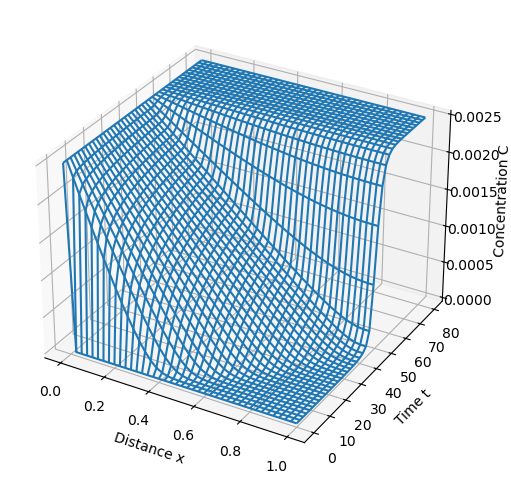

In [6]:
def model_plot(m):
    t = sorted(m.t)
    x = sorted(m.x)

    xgrid = np.zeros((len(t), len(x)))
    tgrid = np.zeros((len(t), len(x)))
    cgrid = np.zeros((len(t), len(x)))

    for i in range(0, len(t)):
        for j in range(0, len(x)):
            xgrid[i,j] = x[j]
            tgrid[i,j] = t[i]
            cgrid[i,j] = m.c[t[i], x[j]].value

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('Distance x')
    ax.set_ylabel('Time t')
    ax.set_zlabel('Concentration C')
    p = ax.plot_wireframe(xgrid, tgrid, cgrid)

# visualization
model_plot(m)

## Dimensional analysis

$$
\begin{align*}
x & = L x' \\
c & = C c' \\
t & = T t' \\
\end{align*}
$$

$$
\begin{align*}
\left[1 + \frac{q K}{(1 + K C c')^2}\right]\frac{\partial c'}{\partial t'} & = \frac{TD}{L^2} \frac{\partial^2 c'}{\partial x'^2} \\
\end{align*}
$$

Assuming $L$ is determined by the experimental apparatus, choose

$$
\begin{align*}
T & = \frac{L^2}{D} \\
C & = \frac{1}{K} \\
\end{align*}
$$

which results in a one parameter model

$$
\begin{align*}
\left[1 + \frac{\alpha}{(1 + c')^2}\right]\frac{\partial c'}{\partial t'} & =  \frac{\partial^2 c'}{\partial x'^2} \\
\end{align*}
$$

where $\alpha = q K$ represents a dimensionless capacity of the substrate to absorb the diffusing molecule.

## Dimensionless Pyomo model

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 20501
  Number of variables: 20503
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 1.4203851222991943
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


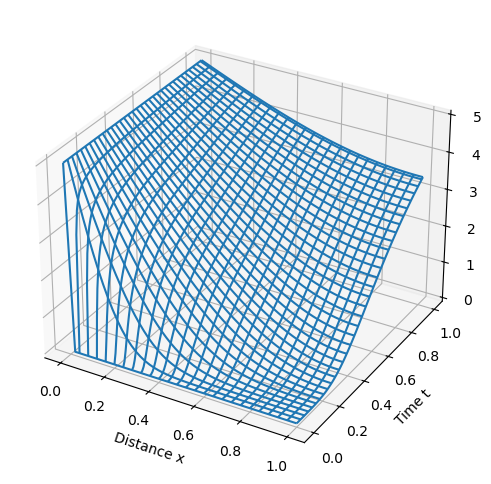

In [7]:
import pyomo.environ as pyo
import pyomo.dae as dae

# parameters
tf = 1.00
Cs = 5.0
alpha = 5.0

m = pyo.ConcreteModel()

m.t = dae.ContinuousSet(bounds=(0, tf))
m.x = dae.ContinuousSet(bounds=(0, 1))

m.c = pyo.Var(m.t, m.x)
m.s = pyo.Var(m.t, m.x)

m.dcdt = dae.DerivativeVar(m.c, wrt=m.t)
m.dcdx = dae.DerivativeVar(m.c, wrt=m.x)
m.d2cdx2 = dae.DerivativeVar(m.c, wrt=(m.x, m.x))

@m.Constraint(m.t, m.x)
def pde(m, t, x):
    return m.dcdt[t, x] * (1 + alpha/(1 + m.c[t, x])** 2) == m.d2cdx2[t, x]

@m.Constraint(m.t)
def bc1(m, t):
    return m.c[t, 0] == Cs

@m.Constraint(m.t)
def bc2(m, t):
    return m.dcdx[t, 1] == 0

@m.Constraint(m.x)
def ic(m, x):
    if (x == 0) or (x == 1):
        return pyo.Constraint.Skip
    return m.c[0, x] == 0.0

# transform and solve
pyo.TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.x, nfe=50)
pyo.TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=100)
pyo.SolverFactory('ipopt').solve(m).write()

model_plot(m)